<a href="https://colab.research.google.com/github/AayushJha2208/AQIMSTproject/blob/main/code-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# Import Libraries
# ==============================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib

In [22]:
# ==============================
# Load Dataset
# ==============================

df = pd.read_csv("Air_quality_data.csv")

# Parse datetime
df["Datetime"] = pd.to_datetime(df["Datetime"])

# Select relevant columns
cols_to_keep = ["Datetime","City","PM2.5","PM10","NO2","SO2","CO","O3","AQI"]
df = df[cols_to_keep]

# Sort properly by City and Datetime
df = df.sort_values(["City", "Datetime"]).reset_index(drop=True)

# Forward fill missing values per city
df = df.groupby("City").apply(lambda x: x.ffill()).reset_index(drop=True)

df = df.dropna()

/tmp/ipython-input-2409664783.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("City").apply(lambda x: x.ffill()).reset_index(drop=True)


In [23]:
# ==============================
# Feature Engineering
# ==============================

# Create next-day target per city
df["AQI_t+1"] = df.groupby("City")["AQI"].shift(-1)

# Create lag and rolling features per city
for col in ["AQI","PM2.5","PM10","NO2","SO2","CO","O3"]:
    df[f"{col}_lag1"] = df.groupby("City")[col].shift(1)
    df[f"{col}_rmean3"] = (
        df.groupby("City")[col]
        .rolling(3)
        .mean()
        .reset_index(level=0, drop=True)
    )
    df[f"{col}_rmean7"] = (
        df.groupby("City")[col]
        .rolling(7)
        .mean()
        .reset_index(level=0, drop=True)
    )

df = df.dropna().reset_index(drop=True)

# Now encode city
df = pd.get_dummies(df, columns=["City"], drop_first=True)

In [30]:
# ==============================
# Train-Test Split
# ==============================

FEATURES = [c for c in df.columns if c not in ["Datetime","AQI","AQI_t+1"]]
TARGET = "AQI"

X = df[FEATURES].values
y = df[TARGET].values

split_idx = int(len(df)*0.7)

X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (12761, 31)
Test size: (5469, 31)


Linear Regression → RMSE: 77.63, MAE: 62.91, R²: 0.53
Decision Tree → RMSE: 10.45, MAE: 2.31, R²: 0.99
Random Forest → RMSE: 9.49, MAE: 2.39, R²: 0.99


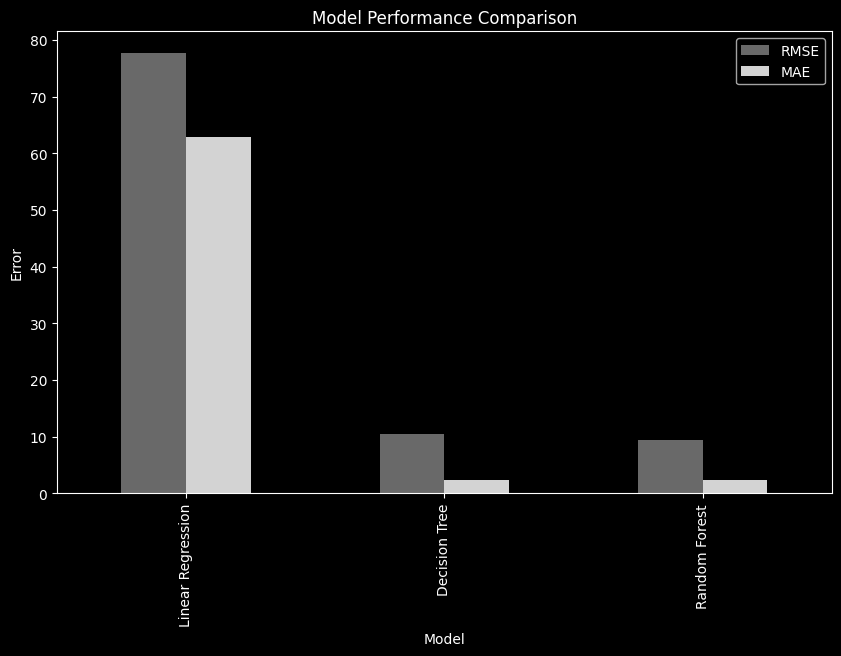

In [31]:
# ==============================
# Model Comparison (Bar Graph)
# ==============================

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=50, random_state=42))
]
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []
for name, model in models:
    results.append(evaluate_model(model, name))

results_df = pd.DataFrame(results)

plt.style.use('dark_background')
results_df.set_index("Model")[["RMSE","MAE"]].plot(kind="bar", figsize=(10,6), color=['dimgray','lightgray'])
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.show()
plt.style.use('default')

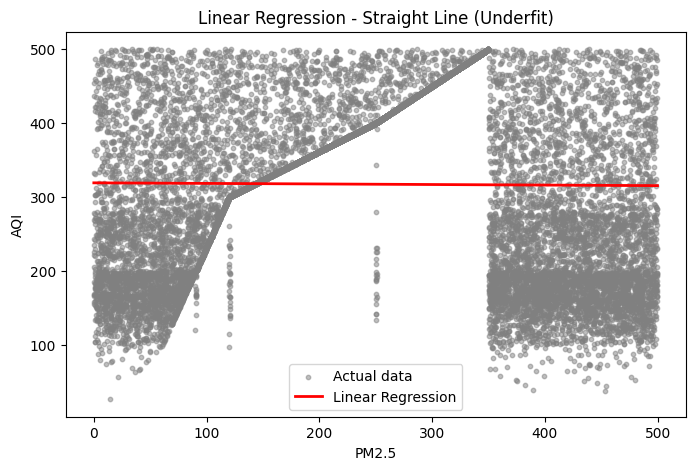

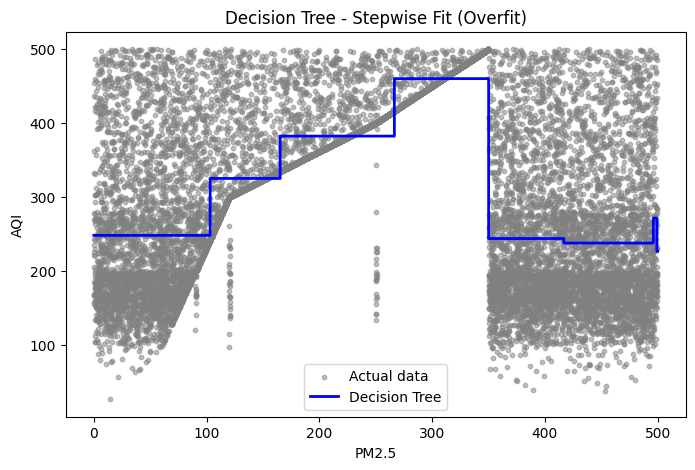

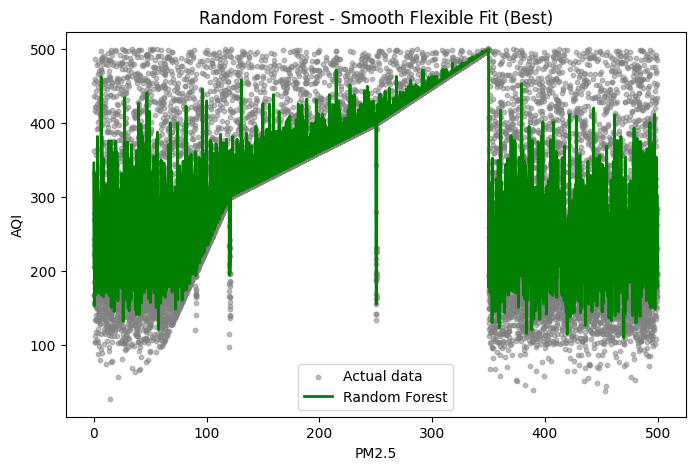

In [32]:
# ==============================
# Line Graph
# ==============================


X_demo = df[["PM2.5"]].values
y_demo = df["AQI"].values

# Sort for plotting
sort_idx = X_demo[:,0].argsort()
X_sorted = X_demo[sort_idx]
y_sorted = y_demo[sort_idx]

# Train models
lin = LinearRegression().fit(X_demo, y_demo)
tree = DecisionTreeRegressor(max_depth=3, random_state=42).fit(X_demo, y_demo)
rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_demo, y_demo)

# Predictions
lin_pred = lin.predict(X_sorted)
tree_pred = tree.predict(X_sorted)
rf_pred = rf.predict(X_sorted)

# ---- Plot Linear Regression ----
plt.figure(figsize=(8,5))
plt.scatter(X_demo, y_demo, s=10, color="gray", alpha=0.5, label="Actual data")
plt.plot(X_sorted, lin_pred, color="red", linewidth=2, label="Linear Regression")
plt.xlabel("PM2.5")
plt.ylabel("AQI")
plt.title("Linear Regression - Straight Line (Underfit)")
plt.legend()
plt.show()

# ---- Plot Decision Tree ----
plt.figure(figsize=(8,5))
plt.scatter(X_demo, y_demo, s=10, color="gray", alpha=0.5, label="Actual data")
plt.step(X_sorted.flatten(), tree_pred, color="blue", linewidth=2, where="mid", label="Decision Tree")
plt.xlabel("PM2.5")
plt.ylabel("AQI")
plt.title("Decision Tree - Stepwise Fit (Overfit)")
plt.legend()
plt.show()

# ---- Plot Random Forest ----
plt.figure(figsize=(8,5))
plt.scatter(X_demo, y_demo, s=10, color="gray", alpha=0.5, label="Actual data")
plt.plot(X_sorted, rf_pred, color="green", linewidth=2, label="Random Forest")
plt.xlabel("PM2.5")
plt.ylabel("AQI")
plt.title("Random Forest - Smooth Flexible Fit (Best)")
plt.legend()
plt.show()


In [36]:
# ==============================
# Baseline Model
# ==============================

baseline_pred = df["AQI"].iloc[split_idx:].values

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print("Baseline RMSE:", baseline_rmse)



Baseline RMSE: 0.0


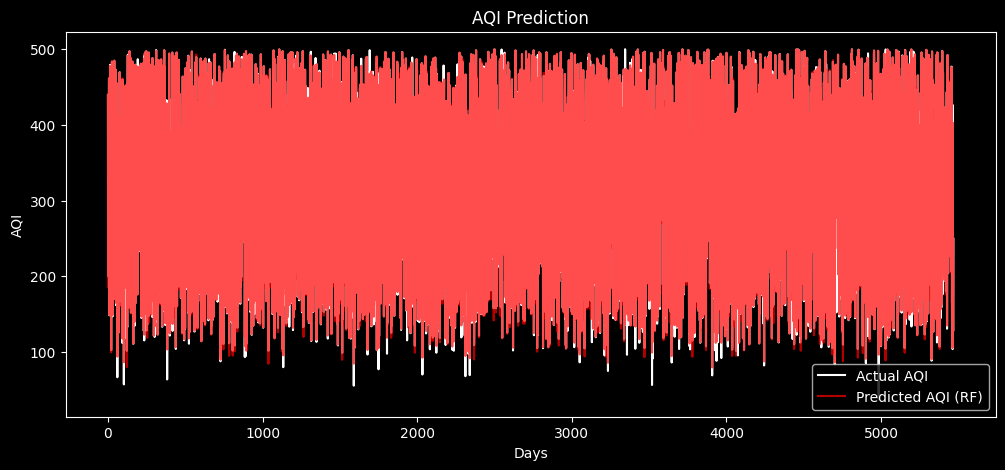

In [34]:
# ==============================
# Predicted vs Actual
# ==============================

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Actual AQI", color="white")
plt.plot(rf_pred, label="Predicted AQI (RF)", color="red", alpha=0.7)
plt.title("AQI Prediction")
plt.xlabel("Days")
plt.ylabel("AQI")
plt.legend()
plt.show()
plt.style.use('default')


Random Forest → RMSE: 9.49, MAE: 2.39, R²: 0.99


/tmp/ipython-input-1101206368.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15], palette='viridis')


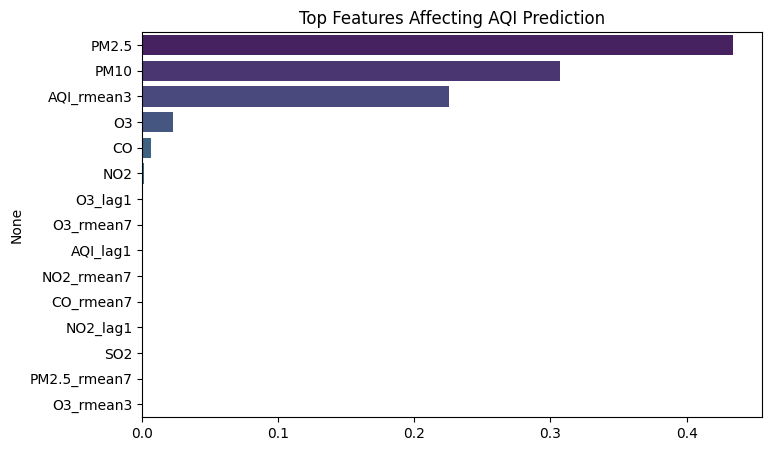

In [35]:
# ==============================
# Results & Feature Importance
# ==============================

evaluate_model(rf, "Random Forest")

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=FEATURES).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15], palette='viridis')
plt.title("Top Features Affecting AQI Prediction")
plt.show()

results = pd.DataFrame({
    "Date": df["Datetime"].iloc[split_idx:],
    "Actual_AQI": y_test,
    "Predicted_RF": rf_pred
})

results.to_csv("aqi_predictions.csv", index=False)

In [ ]:
# ==============================
# Download Model
# ==============================

joblib.dump(rf, "aqi_model.pkl", compress=5)

from google.colab import files
files.download("aqi_model.pkl")